## **Q1**

In [1]:
import torch  # now import the tensorflow module
from torch import nn
import numpy as np 
from torch.utils.data import Dataset,DataLoader
import pandas as pd


In [2]:
print(torch.__version__)

2.4.1+cpu


In [3]:
print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels.shape)
print("Test features shape:", test_features.shape)
print("Test labels shape:", test_labels.shape)

print("Train dataset sample:")
for i in range(10):  # Checking first 3 samples
    print(f"Sample {i}: {train_dataset[i]}")

print("\nValidation dataset sample:")
for i in range(10):
    print(f"Sample {i}: {val_dataset[i]}")

print("\nTest dataset sample:")
for i in range(10):
    print(f"Sample {i}: {test_dataset[i]}")


NameError: name 'train_features' is not defined

In [4]:
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer

from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import Imputer, StandardScaler, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy

from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import roc_curve
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [5]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']

binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment','urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_multiclass = udf(lambda name: 
                                  #normal
                                  0.0 if name == 'normal' else 
                                  #DoS
                                  1.0 if name in ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', ' processtable',
                                                   'smurf', 'teardrop', 'udpstorm', 'worm'] else
                                  #R2L
                                  2.0 if name in ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 'phf',
                                                   'sendmail', 'Snmpgetattack', 'spy', 'snmpguess', 'warezclient', 'warezmaster', 'xlock', 'xsnoop'] else
                                  #U2R
                                  3.0 if name in ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm'] else
                                  #Probing
                                  4.0 if name in ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'] else
                                  0.0, DoubleType())
        output_df = dataset.withColumn('outcome',label_to_multiclass(col('class'))).drop("class")
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))
        return output_df
    
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df
    

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                                "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")
    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol='features')
    # Stage for creating the outcome column representing whether there is attack
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
                                        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])

    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
                            stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline

In [6]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType
from pyspark.ml import Transformer

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment','urgent', 'hot',
                   'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
                   'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
                   'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
                   'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
                   'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
                   'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
                   'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
                   'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer):
    def __init__(self):
        super().__init__()
        self.unaccounted_labels = []

    def _transform(self, dataset):
        def label_to_multiclass(name):
            if name == 'normal':
                return 0.0
            elif name in ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable',
                          'smurf', 'teardrop', 'udpstorm', 'worm']:
                return 1.0
            elif name in ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 'phf',
                          'sendmail', 'Snmpgetattack', 'spy', 'snmpguess', 'warezclient', 'warezmaster', 'xlock', 'xsnoop']:
                return 2.0
            elif name in ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']:
                return 3.0
            elif name in ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']:
                return 4.0
            else:
                if name not in self.unaccounted_labels:
                    self.unaccounted_labels.append(name)
                return None 

        label_to_multiclass_udf = udf(label_to_multiclass, DoubleType())
        output_df = dataset.withColumn('outcome', label_to_multiclass_udf(col('class'))).drop("class")
        
        output_df = output_df.na.drop(subset=["outcome"])
        output_df = output_df.drop('difficulty')

        if self.unaccounted_labels:
            print("Unaccounted labels:", self.unaccounted_labels)

        return output_df

class FeatureTypeCaster(Transformer):
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name, col(col_name).cast(DoubleType()))
        return output_df

class ColumnDropper(Transformer):
    def __init__(self, columns_to_drop=None):
        super().__init__()
        self.columns_to_drop = columns_to_drop

    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    stage_typecaster = FeatureTypeCaster()
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols=nominal_cols, outputCols=nominal_id_cols)
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)
    
    feature_cols = continuous_cols + binary_cols + nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                                "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")
    stage_scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')
    stage_outcome = OutcomeCreater()
    stage_column_dropper = ColumnDropper(columns_to_drop=nominal_cols + nominal_id_cols + nominal_onehot_cols + binary_cols + continuous_cols + ['vectorized_features'])

    pipeline = Pipeline(stages=[stage_typecaster, stage_nominal_indexer, stage_nominal_onehot_encoder,
                                stage_vector_assembler, stage_scaler, stage_outcome, stage_column_dropper])
    return pipeline


In [7]:
# create spark session
# Uncomment the following lines if you are using Windows!
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

appName = "Data Engineering"
master = "local"
# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()


# pass data through preprocessing pipeline 
file_path_train = r"C:\Users\nickc\OneDrive\Documents\GitHub\hw5-sparkml-nick1117\NSL-KDD\KDDTrain+.txt"
file_path_test = r"C:\Users\nickc\OneDrive\Documents\GitHub\hw5-sparkml-nick1117\NSL-KDD\KDDTest+.txt"

nslkdd_raw = spark.read.csv(file_path_train,header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv(file_path_test,header=False).toDF(*col_names)

print(nslkdd_raw.count())

# pipeline = get_preprocess_pipeline()

# pipeline_model = pipeline.fit(nslkdd_raw)

# nslkdd_df_train = pipeline_model.transform(nslkdd_raw)
# nslkdd_df_test = pipeline_model.transform(nslkdd_test_raw)

# # udf function
# to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType())) # keep as is

# # then split into train, validate, test
# nslkdd_df_test, nslkdd_df_validate = nslkdd_df_test.randomSplit([0.5, 0.5], seed=42)

# # convert to pandas (nslkdd_df_train -> nslkdd_df_train_pandas)
# # nslkdd_df_train_pandas = nslkdd_df_train.withColumn('features', to_array('features')).toPandas()
# nslkdd_df_train_pandas = nslkdd_df_train.withColumn('features', to_array('features')).toPandas()
# nslkdd_df_validate_pandas = nslkdd_df_validate.withColumn('features', to_array('features')).toPandas()
# nslkdd_df_test_pandas = nslkdd_df_test.withColumn('features', to_array('features')).toPandas()

# x_train = torch.from_numpy(np.array(nslkdd_df_train_pandas['features'].values.tolist(),np.float32))
# y_train = torch.from_numpy(np.array(nslkdd_df_train_pandas['outcome'].values.tolist(),np.int64))

# x_validate = torch.from_numpy(np.array(nslkdd_df_validate_pandas['features'].values.tolist(),np.float32))
# y_validate = torch.from_numpy(np.array(nslkdd_df_validate_pandas['outcome'].values.tolist(),np.int64))

# x_test = torch.from_numpy(np.array(nslkdd_df_test_pandas['features'].values.tolist(),np.float32))
# y_test = torch.from_numpy(np.array(nslkdd_df_test_pandas['outcome'].values.tolist(),np.int64))

# class MyDataset(Dataset): 
#     def __init__(self, x, y):
#         # self.x = torch.tensor(x.values, dtype=torch.float32)
#         # self.y = torch.tensor(y.values, dtype=torch.long)
#         self.x = x
#         self.y = y

#     def __len__(self):
#         return self.x.shape[0]

#     def __getitem__(self, idx):
#         return (self.x[idx], self.y[idx])

# train_dataset = MyDataset(x_train, y_train)
# validate_dataset = MyDataset(x_validate, y_validate)
# test_dataset = MyDataset(x_test, y_test)



C:\spark\spark-3.5.2-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


125973


In [11]:
for i in range(10):
    print(train_dataset[i])


(tensor([0.0000e+00, 8.3641e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.7466e-02, 2.7535e-02, 0.0000e+00, 0.0000e+00, 2.2747e+00,
        0.0000e+00, 0.0000e+00, 1.5120e+00, 2.2583e-01, 3.7866e-01, 1.5880e-01,
        5.5017e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.5762e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.4069e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e

## **Q2**

In [65]:
class myMultiLayerPerceptron(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        #better model for val accuarcy
        self.sequential = nn.Sequential(  # here we stack multiple layers together
            nn.Linear(input_dim,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,output_dim)
        )
    #     self.sequential = nn.Sequential(
    #         nn.Linear(input_dim, 64),
    #         nn.ReLU(),
    #         nn.Dropout(0.3),
    #         nn.Linear(64, 128),
    #         nn.ReLU(),
    #         nn.Dropout(0.3),
    #         nn.Linear(128, 128),
    #         nn.ReLU(),
    #         nn.Dropout(0.3),
    #         nn.Linear(128, 64),
    #         nn.ReLU(),
    #         nn.Dropout(0.3),
    #         nn.Linear(64, output_dim)
    #     )
    def forward(self,x):
        y = self.sequential(x)
        return y
    
# Let's check out our model 

input_dim = x_train.shape[1]
output_dim = 5 # 5 categories

mymodel = myMultiLayerPerceptron(input_dim,output_dim) # creating a model instance with input dimension 1 and output dimension 1

print(mymodel)

myMultiLayerPerceptron(
  (sequential): Sequential(
    (0): Linear(in_features=113, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): ReLU()
    (8): Linear(in_features=20, out_features=5, bias=True)
  )
)


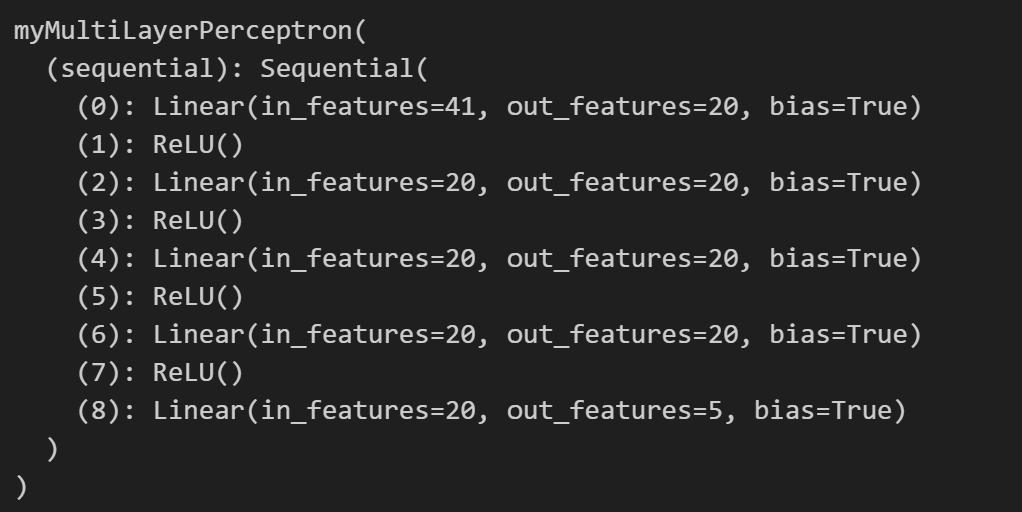

## **Q3**

Write a training loop that contains at least the following features: conduct validation
for each epoch; compute the train/validate loss/metric for each epoch; print out the progress
of each epoch; save the current best model so far at every epoch. You may choose your own
metric.

Further, after the training loop, plot three figures

• The train loss per SGD iteration, that is, the train loss of every batch across all batches
in all epochs. The horizontal axis should range from 1 to the total number of train
iterations, which equals (number of epochs)*(number of batches in training data).

• The train and validate loss across different epochs.

• The train and validate metric across different epochs.

Please select your own hyper-parameters and conduct a run of the training loop, and in your
submission, include a screenshot of the printout of the training loop and the three figures.

In [47]:
import io
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

# Three hyper parameters for training
lr = .04
batch_size = 10
N_epochs = 160

#batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.SGD(mymodel.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss() #Classification problem

best_val_loss = float('inf') #infinity?
best_model = None

train_losses = [] ## end of epoch
train_accuracies = [] ## end of epoch
validate_losses = [] ## end of epoch
validate_accuracies = [] ## end of epoch
losses_all = [] #for end of batch

for epoch in range(N_epochs):
    print(f"Run Epoch")

    mymodel.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for x_batch, y_batch in train_loader:
        # pass input data to get the prediction outputs by the current model
        prediction = mymodel(x_batch)

        # compare prediction and the actual output and compute the loss
        loss = criterion(prediction, y_batch)

        # compute the gradient
        optimizer.zero_grad()
        loss.backward()

        # update parameters
        optimizer.step()
        
        #training loss
        running_train_loss += loss.item()
        losses_all.append(running_train_loss)

        #accuracy
        _, predicted = torch.max(prediction, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    mymodel.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): #repeat for train
        for x_batch, y_batch in val_loader:
            # print({y_batch})
            # break
            prediction = mymodel(x_batch)
            loss = criterion(prediction, y_batch)
            running_val_loss += loss.item()

            _, predicted = torch.max(prediction.data, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    validate_losses.append(val_loss)
    validate_accuracies.append(val_accuracy)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = mymodel.state_dict()

    print(f"Epoch [{epoch+1}/{N_epochs}]: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

Run Epoch
Epoch [1/160]: Train Loss: 0.1247, Train Acc: 0.9651, Val Loss: 2.4834, Val Acc: 0.7557
Run Epoch
Epoch [2/160]: Train Loss: 0.0550, Train Acc: 0.9825, Val Loss: 2.1953, Val Acc: 0.7620
Run Epoch
Epoch [3/160]: Train Loss: 0.0469, Train Acc: 0.9848, Val Loss: 1.6150, Val Acc: 0.7780
Run Epoch
Epoch [4/160]: Train Loss: 0.0414, Train Acc: 0.9869, Val Loss: 1.8511, Val Acc: 0.7780
Run Epoch
Epoch [5/160]: Train Loss: 0.0387, Train Acc: 0.9878, Val Loss: 2.5134, Val Acc: 0.7934
Run Epoch
Epoch [6/160]: Train Loss: 0.0373, Train Acc: 0.9879, Val Loss: 2.2339, Val Acc: 0.7807
Run Epoch
Epoch [7/160]: Train Loss: 0.0358, Train Acc: 0.9887, Val Loss: 3.5244, Val Acc: 0.7769
Run Epoch
Epoch [8/160]: Train Loss: 0.0349, Train Acc: 0.9888, Val Loss: 2.1086, Val Acc: 0.8090
Run Epoch
Epoch [9/160]: Train Loss: 0.0329, Train Acc: 0.9894, Val Loss: 2.5773, Val Acc: 0.7936
Run Epoch
Epoch [10/160]: Train Loss: 0.0310, Train Acc: 0.9899, Val Loss: 2.3958, Val Acc: 0.7937
Run Epoch
Epoch [11

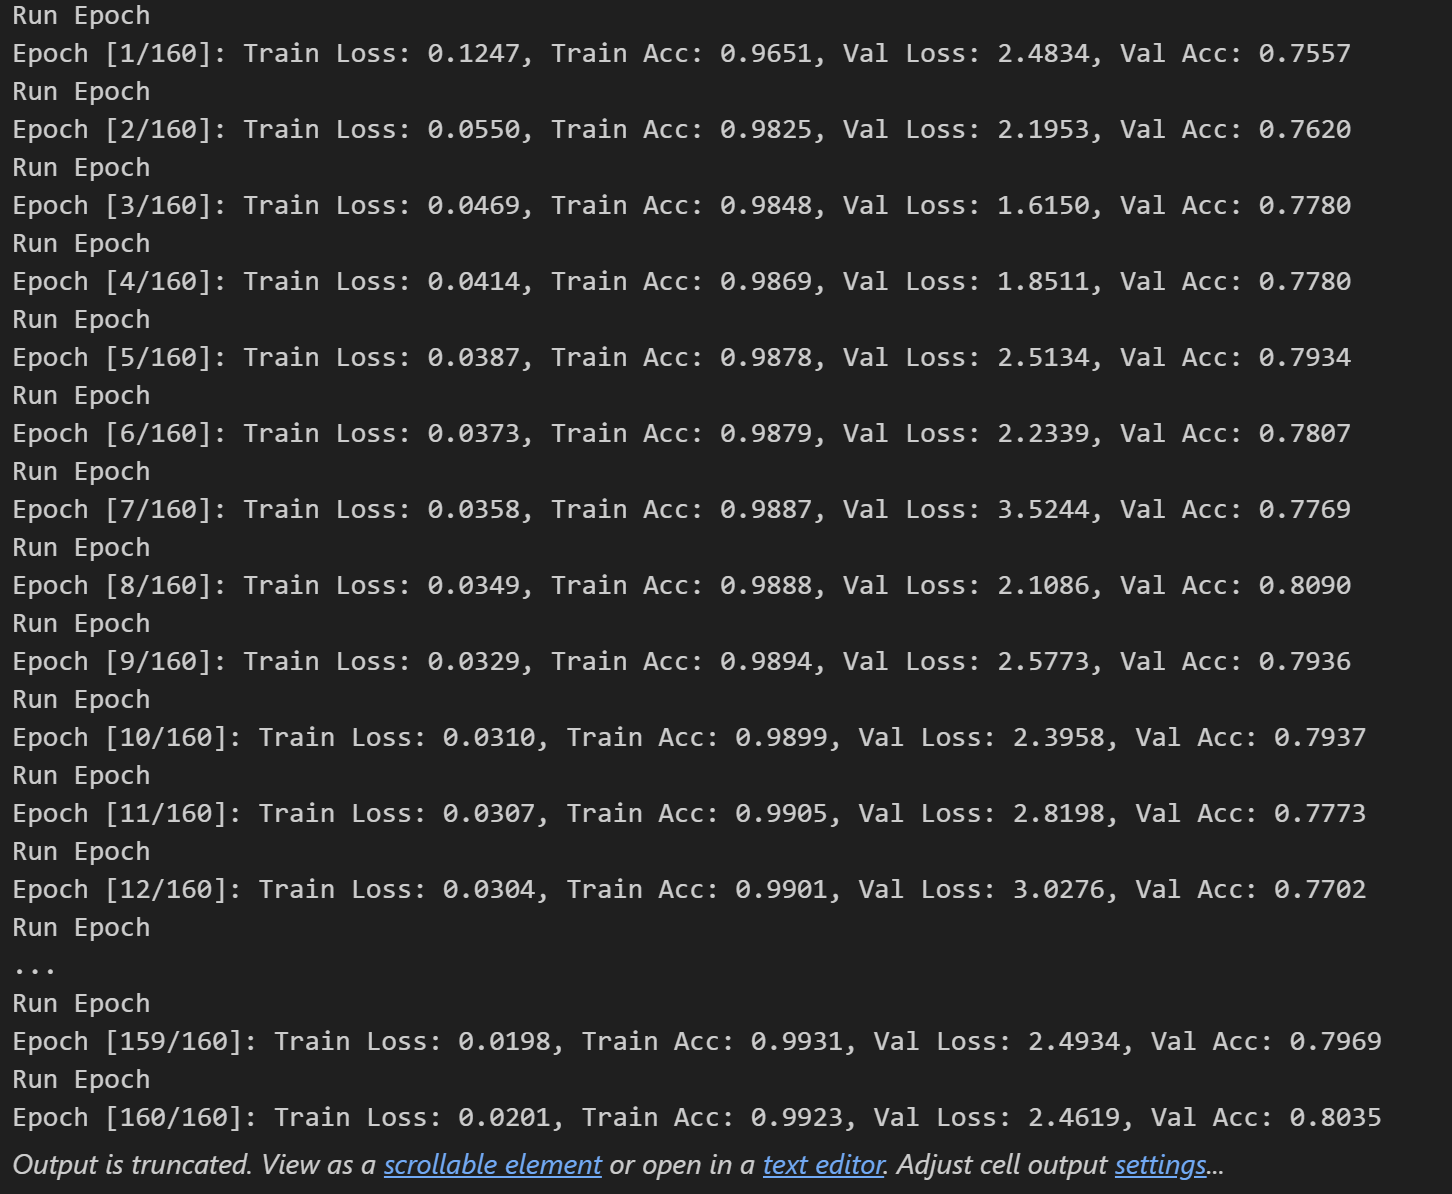

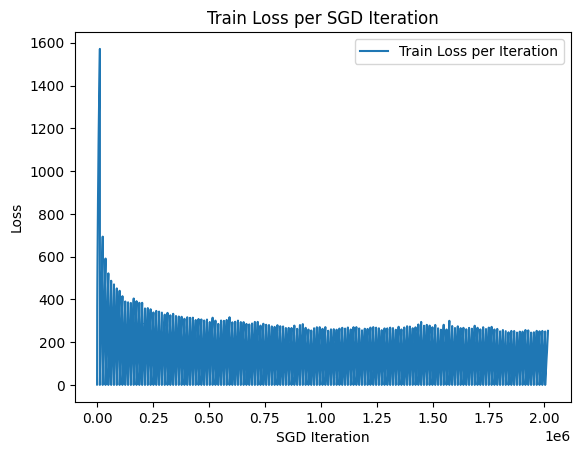

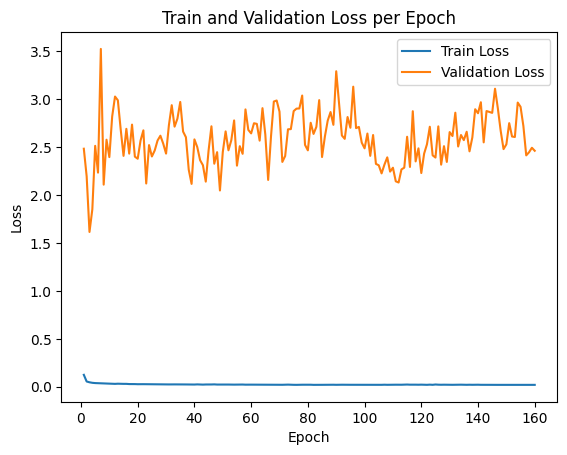

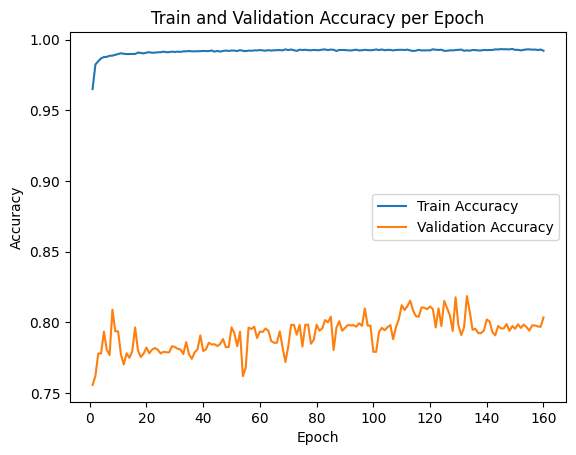

In [48]:
total_iterations = N_epochs * len(train_loader)
iterations = list(range(1, total_iterations + 1))

# train Loss per SGD Iteration
plt.figure()
plt.plot(iterations, losses_all, label="Train Loss per Iteration")
plt.xlabel("SGD Iteration")
plt.ylabel("Loss")
plt.title("Train Loss per SGD Iteration")
plt.legend()
plt.show()

# Train and Validate Loss per Epoch
epochs = list(range(1, N_epochs + 1))
plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, validate_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss per Epoch")
plt.legend()
plt.show()

# Train and Validate Accuracy per Epoch
plt.figure()
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, validate_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy per Epoch")
plt.legend()
plt.show()

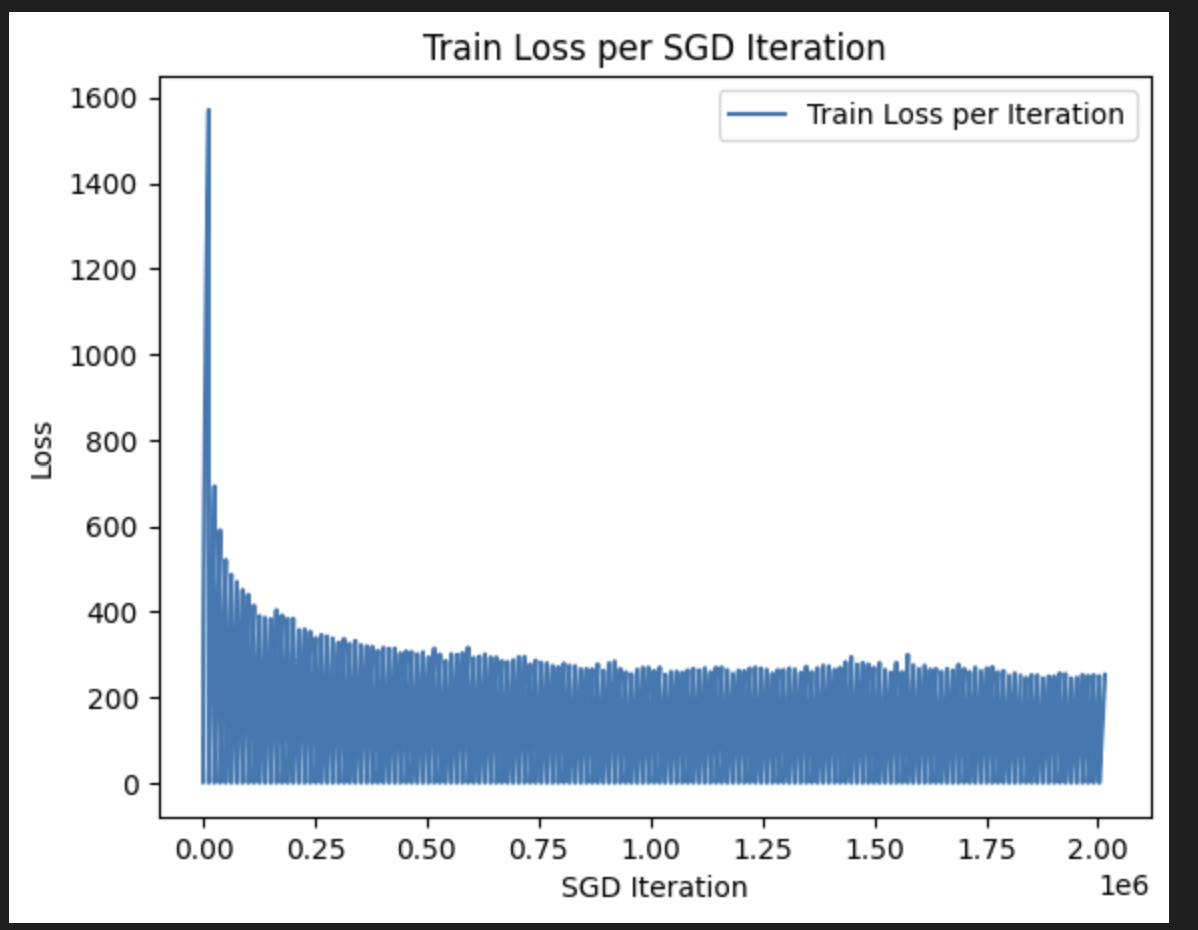

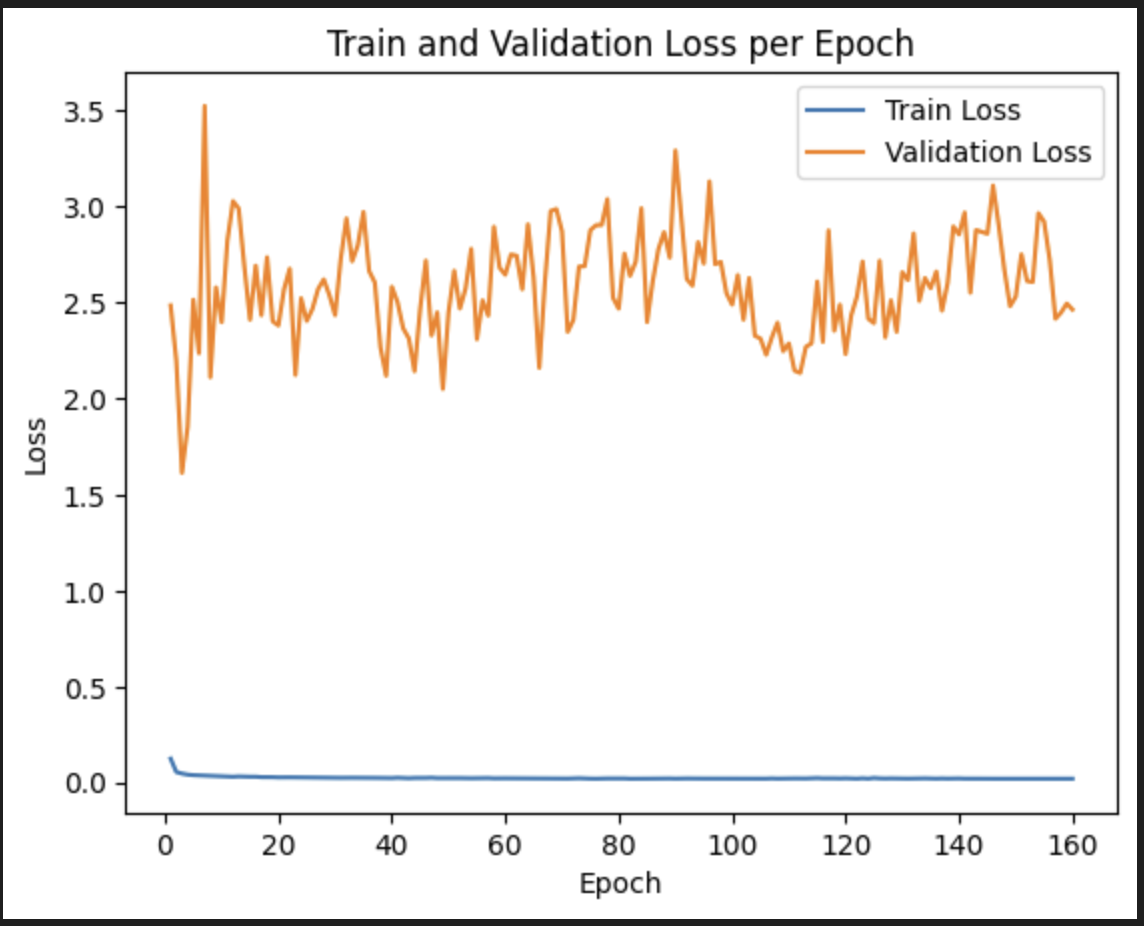

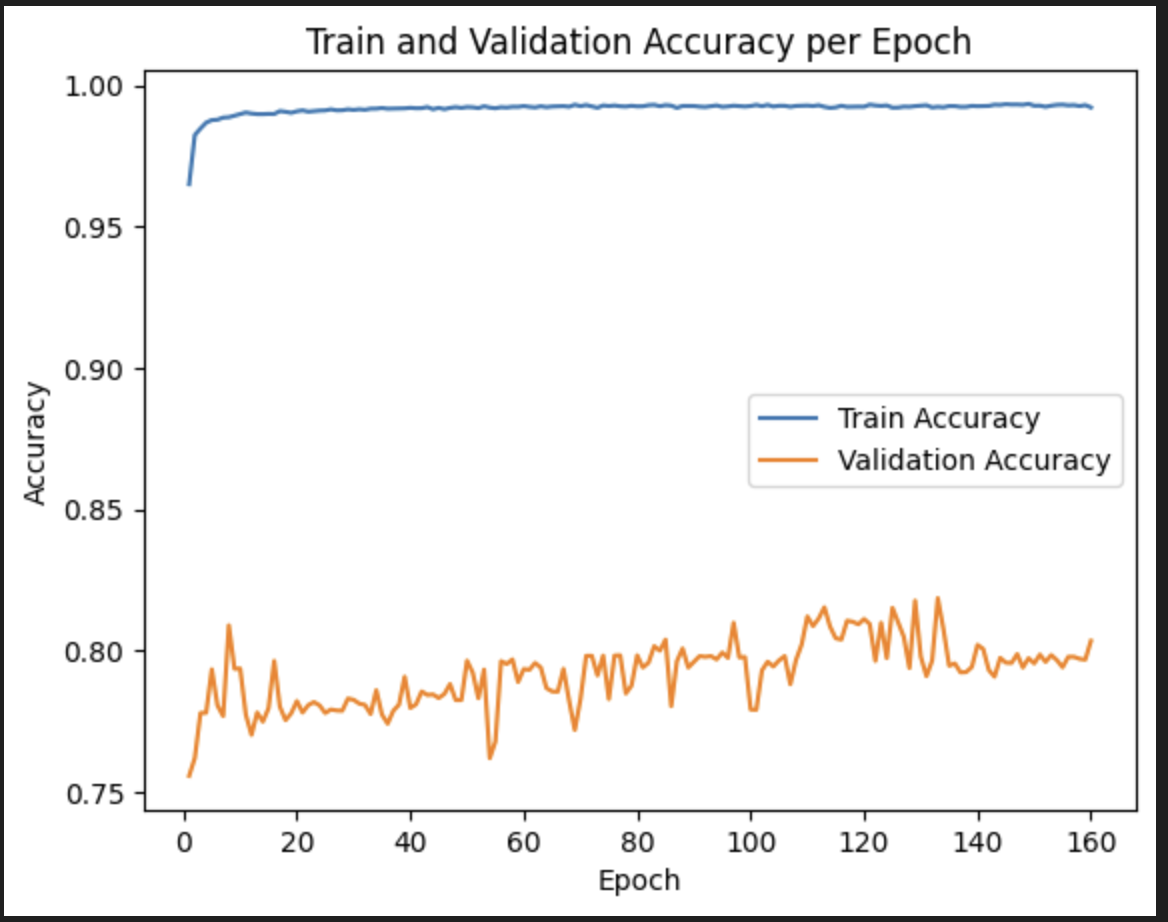

## **Q4**


In [66]:
def test_hyperparameters(lr_test, batch_size_test, N_epoch_test):
    # Three hyper parameters for training
    lr = lr_test
    batch_size = batch_size_test
    N_epochs = N_epoch_test

    #ensure that a new model is created
    mymodel = myMultiLayerPerceptron(input_dim,output_dim)

    #batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
    
    optimizer = torch.optim.SGD(mymodel.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss() #Classification problem

    best_val_loss = float('inf') #infinity?
    best_model = None

    train_losses = [] ## end of epoch
    train_accuracies = [] ## end of epoch
    validate_losses = [] ## end of epoch
    validate_accuracies = [] ## end of epoch
    losses_all = [] #for end of batch

    for epoch in range(N_epochs):
        print(f"Run Epoch")

        mymodel.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for x_batch, y_batch in train_loader:
            # pass input data to get the prediction outputs by the current model
            prediction = mymodel(x_batch)

            # compare prediction and the actual output and compute the loss
            loss = criterion(prediction, y_batch)

            # compute the gradient
            optimizer.zero_grad()
            loss.backward()

            # update parameters
            optimizer.step()
            
            #training loss
            running_train_loss += loss.item()
            losses_all.append(running_train_loss)

            #accuracy
            _, predicted = torch.max(prediction, 1)
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        mymodel.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad(): #repeat for train
            for x_batch, y_batch in val_loader:
                # print({y_batch})
                # break
                prediction = mymodel(x_batch)
                loss = criterion(prediction, y_batch)
                running_val_loss += loss.item()

                _, predicted = torch.max(prediction.data, 1)
                correct_val += (predicted == y_batch).sum().item()
                total_val += y_batch.size(0)

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        validate_losses.append(val_loss)
        validate_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = mymodel.state_dict()

        print(f"Epoch [{epoch+1}/{N_epochs}]: "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
            

    total_iterations = N_epochs * len(train_loader)
    iterations = list(range(1, total_iterations + 1))

    # train Loss per SGD Iteration
    plt.figure()
    plt.plot(iterations, losses_all, label="Train Loss per Iteration")
    plt.xlabel("SGD Iteration")
    plt.ylabel("Loss")
    plt.title("Train Loss per SGD Iteration")
    plt.legend()
    plt.show()

    # Train and Validate Loss per Epoch
    epochs = list(range(1, N_epochs + 1))
    plt.figure()
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, validate_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss per Epoch")
    plt.legend()
    plt.show()

    # Train and Validate Accuracy per Epoch
    plt.figure()
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, validate_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train and Validation Accuracy per Epoch")
    plt.legend()
    plt.show()

    return best_model, best_val_loss
        


Testing with Set 1: lr=0.01, batch_size=32, epochs=100
Run Epoch
Epoch [1/75]: Train Loss: 0.0851, Train Acc: 0.9737, Val Loss: 1.9489, Val Acc: 0.7683
Run Epoch
Epoch [2/75]: Train Loss: 0.0383, Train Acc: 0.9871, Val Loss: 1.9811, Val Acc: 0.7786
Run Epoch
Epoch [3/75]: Train Loss: 0.0320, Train Acc: 0.9894, Val Loss: 2.0721, Val Acc: 0.7767
Run Epoch
Epoch [4/75]: Train Loss: 0.0279, Train Acc: 0.9908, Val Loss: 2.1667, Val Acc: 0.7798
Run Epoch
Epoch [5/75]: Train Loss: 0.0258, Train Acc: 0.9914, Val Loss: 1.7861, Val Acc: 0.7900
Run Epoch
Epoch [6/75]: Train Loss: 0.0244, Train Acc: 0.9920, Val Loss: 1.8332, Val Acc: 0.8157
Run Epoch
Epoch [7/75]: Train Loss: 0.0230, Train Acc: 0.9924, Val Loss: 2.1240, Val Acc: 0.7776
Run Epoch
Epoch [8/75]: Train Loss: 0.0223, Train Acc: 0.9927, Val Loss: 2.4688, Val Acc: 0.7897
Run Epoch
Epoch [9/75]: Train Loss: 0.0221, Train Acc: 0.9929, Val Loss: 2.0480, Val Acc: 0.8145
Run Epoch
Epoch [10/75]: Train Loss: 0.0209, Train Acc: 0.9931, Val Loss

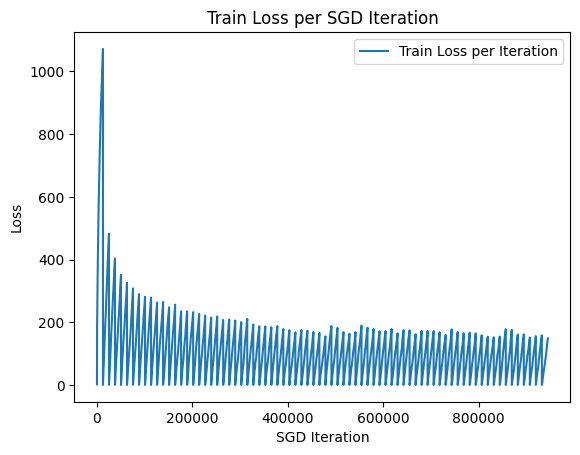

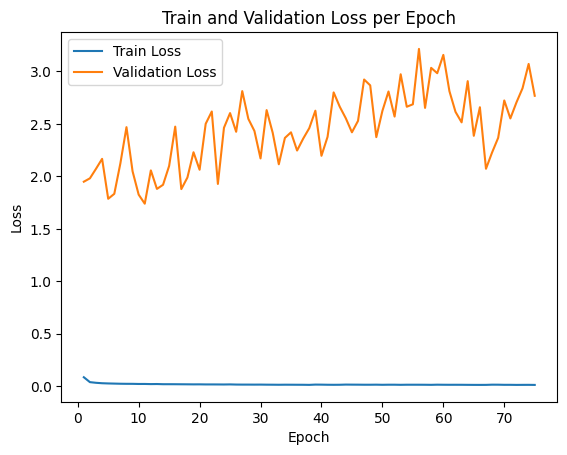

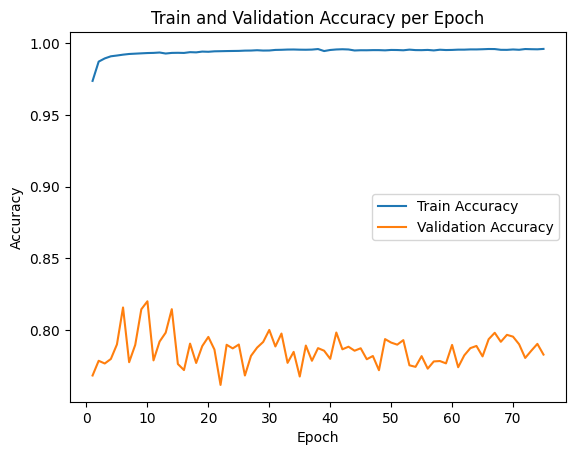

Testing with Set 2: lr=0.05, batch_size=64, epochs=80
Run Epoch
Epoch [1/60]: Train Loss: 0.3087, Train Acc: 0.8896, Val Loss: 1.2942, Val Acc: 0.7515
Run Epoch
Epoch [2/60]: Train Loss: 0.0668, Train Acc: 0.9795, Val Loss: 1.4737, Val Acc: 0.7580
Run Epoch
Epoch [3/60]: Train Loss: 0.0504, Train Acc: 0.9832, Val Loss: 1.4993, Val Acc: 0.7593
Run Epoch
Epoch [4/60]: Train Loss: 0.0403, Train Acc: 0.9861, Val Loss: 1.7693, Val Acc: 0.7629
Run Epoch
Epoch [5/60]: Train Loss: 0.0347, Train Acc: 0.9895, Val Loss: 1.7747, Val Acc: 0.7687
Run Epoch
Epoch [6/60]: Train Loss: 0.0318, Train Acc: 0.9902, Val Loss: 1.7541, Val Acc: 0.7742
Run Epoch
Epoch [7/60]: Train Loss: 0.0295, Train Acc: 0.9904, Val Loss: 1.8889, Val Acc: 0.7730
Run Epoch
Epoch [8/60]: Train Loss: 0.0275, Train Acc: 0.9912, Val Loss: 1.9636, Val Acc: 0.7675
Run Epoch
Epoch [9/60]: Train Loss: 0.0266, Train Acc: 0.9915, Val Loss: 1.9069, Val Acc: 0.7816
Run Epoch
Epoch [10/60]: Train Loss: 0.0255, Train Acc: 0.9919, Val Loss:

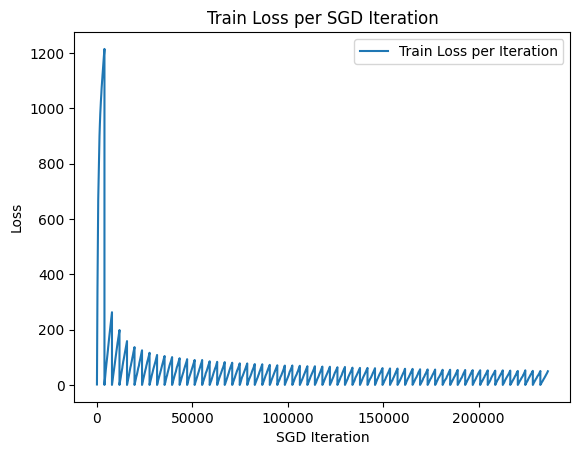

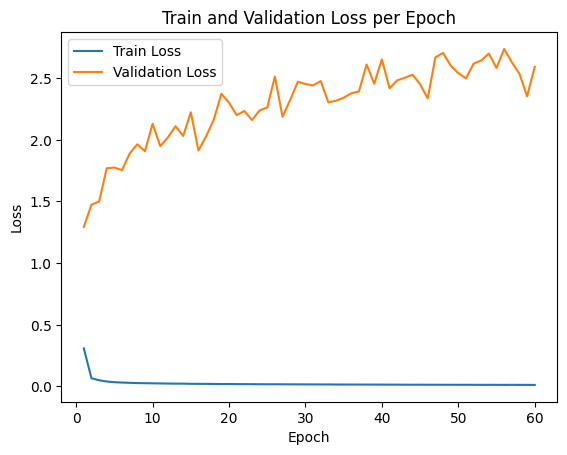

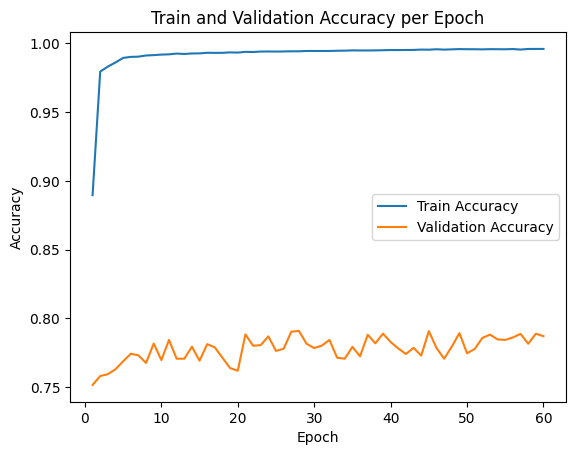

Testing with Set 3: lr=0.001, batch_size=32, epochs=120
Run Epoch
Epoch [1/80]: Train Loss: 1.2630, Train Acc: 0.5346, Val Loss: 1.3072, Val Acc: 0.4292
Run Epoch
Epoch [2/80]: Train Loss: 1.0292, Train Acc: 0.5366, Val Loss: 1.3062, Val Acc: 0.4351
Run Epoch
Epoch [3/80]: Train Loss: 0.8746, Train Acc: 0.7514, Val Loss: 1.2191, Val Acc: 0.6978
Run Epoch
Epoch [4/80]: Train Loss: 0.5660, Train Acc: 0.8759, Val Loss: 1.0820, Val Acc: 0.6751
Run Epoch
Epoch [5/80]: Train Loss: 0.3709, Train Acc: 0.8848, Val Loss: 1.1286, Val Acc: 0.6656
Run Epoch
Epoch [6/80]: Train Loss: 0.2903, Train Acc: 0.8869, Val Loss: 1.2088, Val Acc: 0.6648
Run Epoch
Epoch [7/80]: Train Loss: 0.2498, Train Acc: 0.9086, Val Loss: 1.2573, Val Acc: 0.6799
Run Epoch
Epoch [8/80]: Train Loss: 0.2198, Train Acc: 0.9390, Val Loss: 1.2978, Val Acc: 0.7043
Run Epoch
Epoch [9/80]: Train Loss: 0.1940, Train Acc: 0.9607, Val Loss: 1.3307, Val Acc: 0.7094
Run Epoch
Epoch [10/80]: Train Loss: 0.1706, Train Acc: 0.9670, Val Los

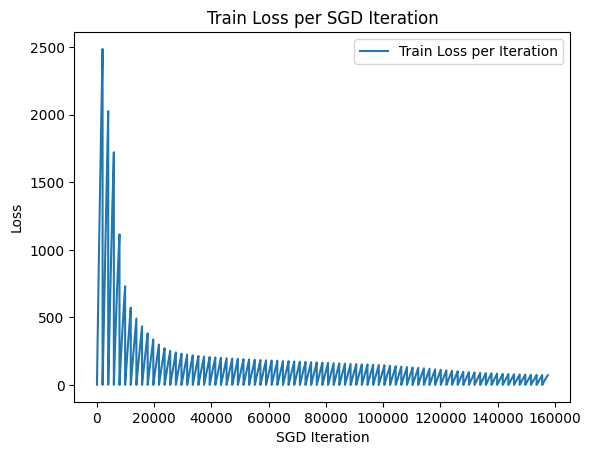

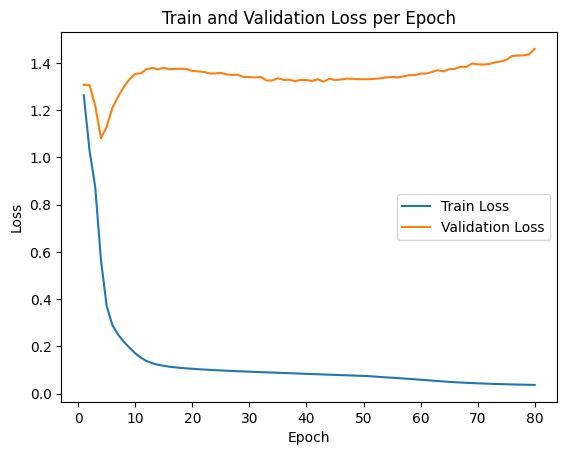

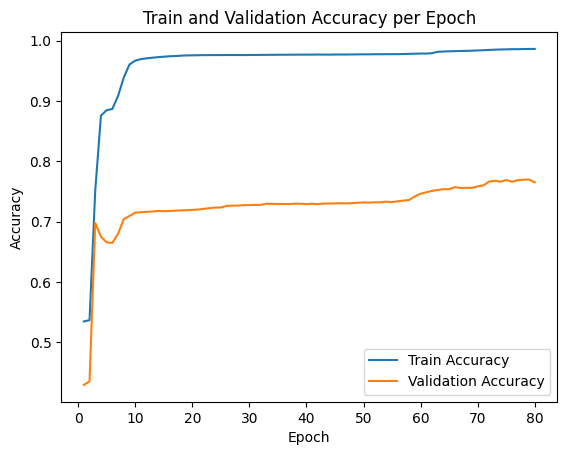

In [ ]:
print("Testing with Set 1: lr=0.01, batch_size=32, epochs=100")
best_model_1, best_val_loss_1 = test_hyperparameters(lr_test=0.05, batch_size_test=10, N_epoch_test=75)

best_model = best_model_1
best_val_loss = best_val_loss_1

print("Testing with Set 2: lr=0.05, batch_size=64, epochs=80")
best_model_2, best_val_loss_2 = test_hyperparameters(lr_test=0.01, batch_size_test=32, N_epoch_test=60)

if best_val_loss_2 < best_val_loss:
    best_model = best_model_2
    best_val_loss = best_val_loss_2

print("Testing with Set 3: lr=0.001, batch_size=32, epochs=120")
best_model_3, best_val_loss_3 = test_hyperparameters(lr_test=0.001, batch_size_test=64, N_epoch_test=80)

if best_val_loss_3 < best_val_loss:
    best_model = best_model_3
    best_val_loss = best_val_loss_3


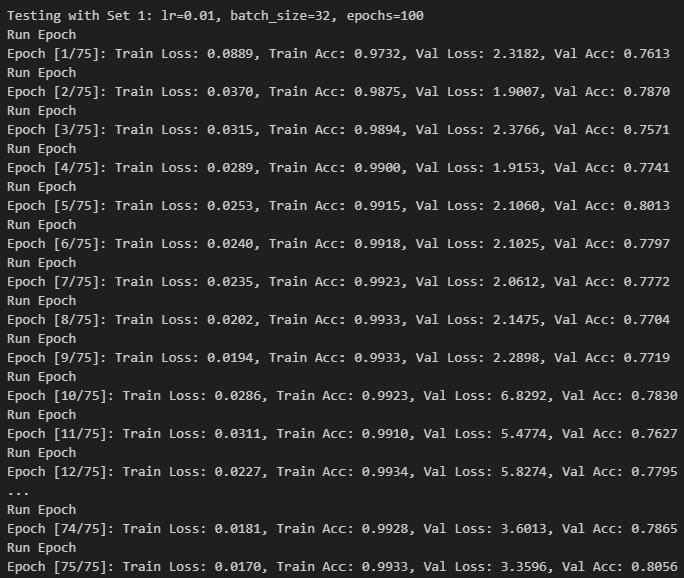

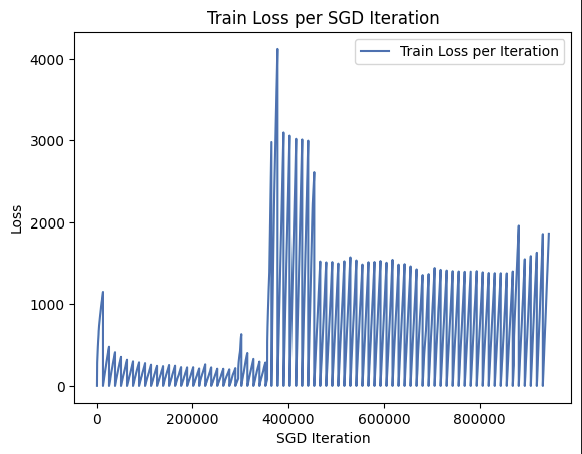

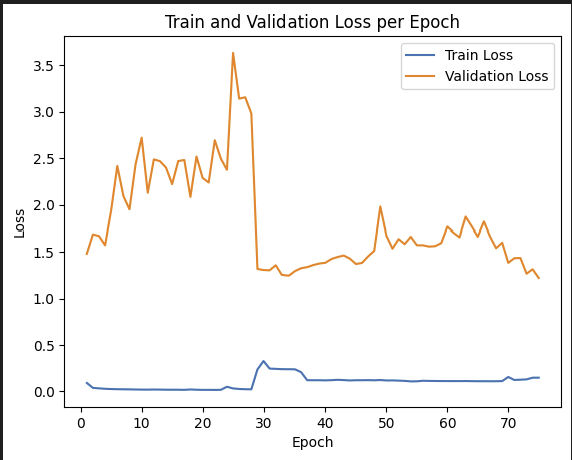

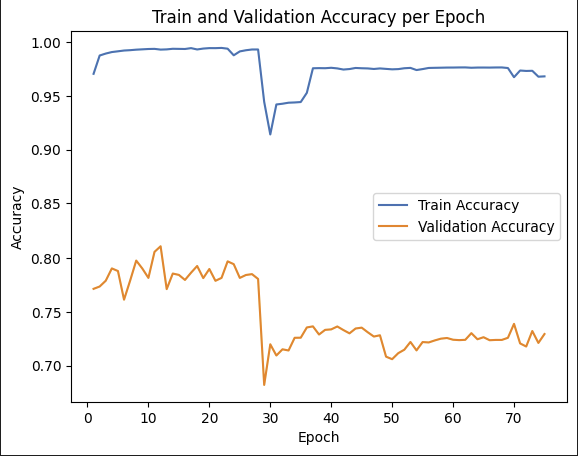

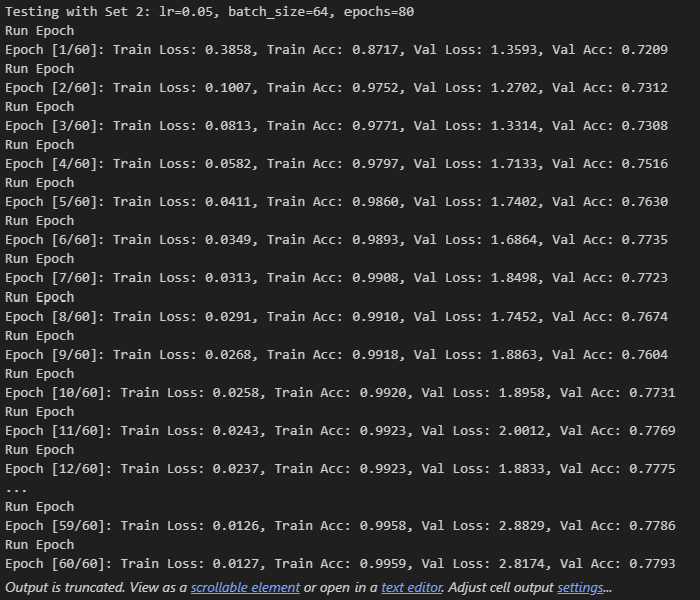

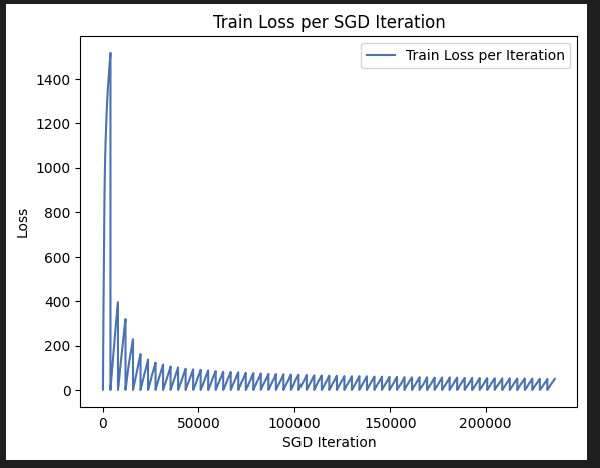

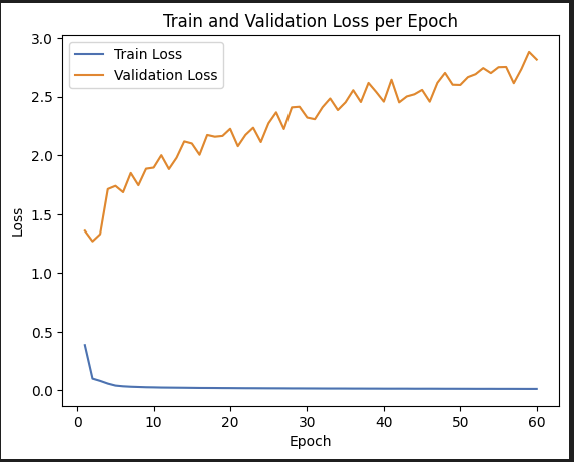

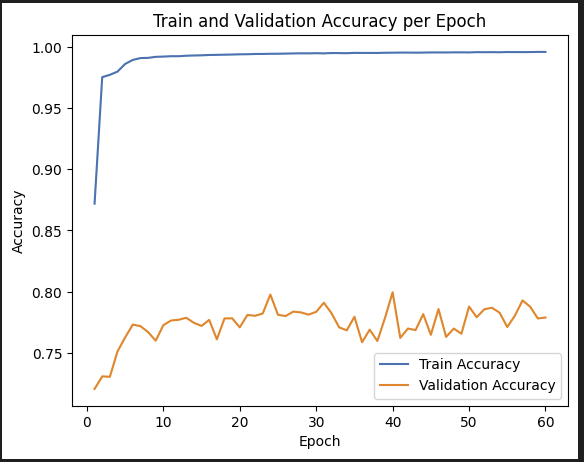

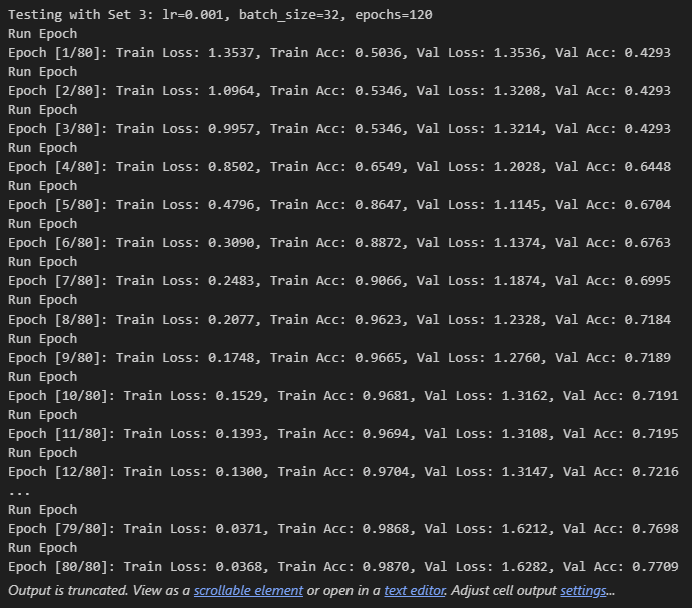

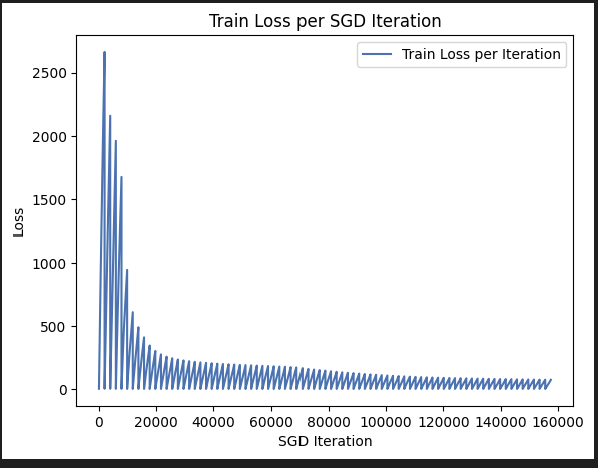

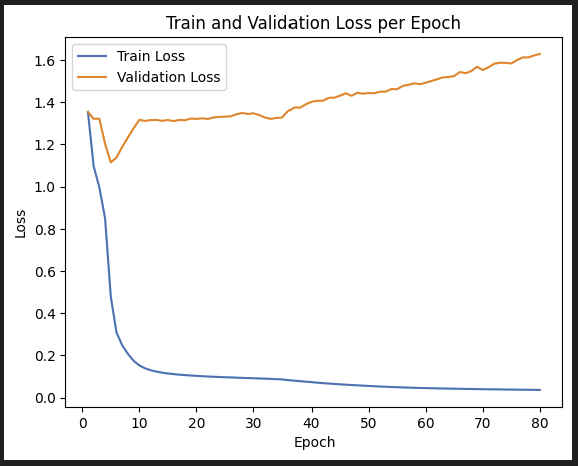

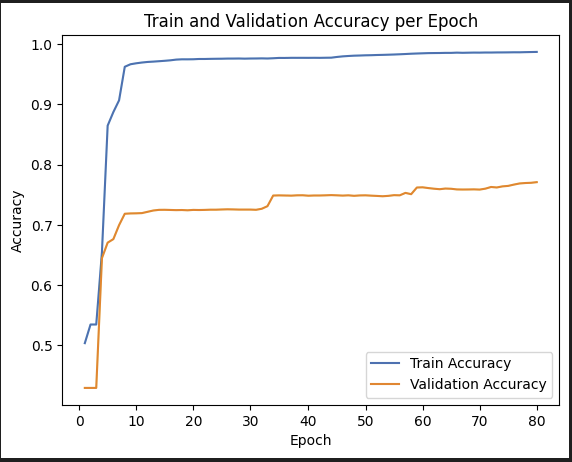

At first I chose lr = 0.01, batch_size = 32, epochs = 100 as a starting point. The learning rate was low but not too low, batch size was 32 as a popular batch size and 100 epochs so it did not run too long. 

After running this, I lowered the learning rate to 0.05 to allow for smoother convergence, increase batch size to 64 to try and stablize gradient update and decrease epochs as validation accuracy levels off before the max epochs.

Finally, I decrease learning rate again to see if it keeps trending in the right direction but might now suffer from overshooting. I go back to a batch size of 32 to generalize better and increase the epochs to confirm converagence is met. 

## **Q5**

In [68]:
mymodel = myMultiLayerPerceptron(input_dim, output_dim)
mymodel.load_state_dict(best_model) 
mymodel.eval() 

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

correct = 0
total = 0

with torch.no_grad(): 
    for x_batch, y_batch in test_loader:
        predictions = mymodel(x_batch)
        _, predicted_labels = torch.max(predictions, 1)
        correct += (predicted_labels == y_batch).sum().item()
        total += y_batch.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7612


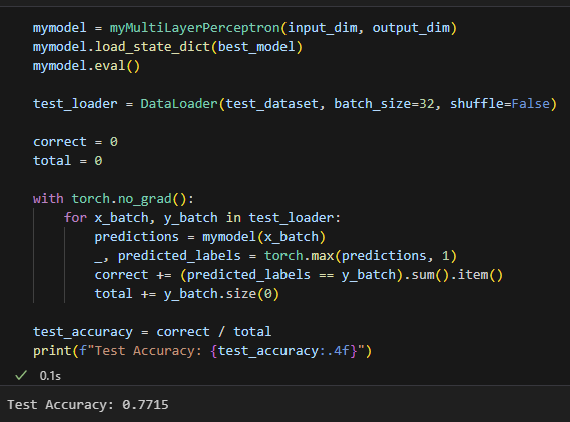